In [1]:
#### Necessary libraries ####
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import xarray as xr
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import cartopy.crs as crs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter  # For 0-360 longitude ticks
from cmocean import cm
import os 

from Functions import * 
from Functions_load2 import *   # Loading models by namelist

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

In [23]:
import glob   # new library added here
files = glob.glob('results*')  
models = [fn[8:] for fn in files]  # List of current models

In [25]:
# # Checking the list of models
# for mn in models:
#     print(mn)

# Data loading

In [4]:
''' Examples of data loading of moisture sources

Data is loaded per individual ensemble member for each model.
All data is converted to mm evaporative sources over the whole time period

List of models at the time of analysis:
univie FLEXPART
CHc LAGRANTO
Ru_Xu_FLEXPART
FLEXPART_WaterSip_TatFanCheng
WAM2layers
Utrack Arie Staal
TRACMASS Dipanjan Dey
Uvigo
B-TrIMS
UGhent HAMSTER
2LDRM
'''

for file in files:
    model_name = file[8:]
    print('Loading %s' % model_name)
    if model_name == "TRACMASS Dipanjan Dey": 
        print('no spatial results')
        continue
    srcs = load_model(model_name)
    
    if model_name ==  "univie FLEXPART":
        srcs_flexpart_univie = srcs
    elif model_name == "CHc LAGRANTO":
        srcs_lagranto_CHc = srcs
    elif model_name ==  "Ru_Xu_FLEXPART":
        srcs_flexpart_xu = srcs
    elif model_name ==  "FLEXPART_WaterSip_TatFanCheng":
        srcs_flexpart_watersip1, srcs_flexpart_watersip2, srcs_flexpart_watersip3 = srcs
    elif model_name ==  "WAM2layers":
        srcs_wam2layers = srcs
    elif model_name ==  "Utrack Arie Staal":
        srcs_utrack_e1, srcs_utrack_e2, srcs_utrack_e3, srcs_utrack_e4, srcs_utrack_e5 = srcs
#     elif model_name ==  "TRACMASS Dipanjan Dey": 
#
    elif model_name ==  "Uvigo":
        srcs_uvigo_e1, srcs_uvigo_e2 = srcs
    elif model_name ==  "B-TrIMS":
        srcs_btrims = srcs
    elif model_name ==  "UGhent HAMSTER":
        srcs_ghent_e1, srcs_ghent_e2, srcs_ghent_e3, srcs_ghent_e4, srcs_ghent_e5 = srcs
    elif model_name ==  "2LDRM":
        srcs_1LDRM, srcs_2LDRM = srcs

Loading univie FLEXPART
using boundary layer only
Loading CHc LAGRANTO
Loading Ru_Xu_FLEXPART
Loading FLEXPART_WaterSip_TatFanCheng
Loading WAM2layers
Loading Utrack Arie Staal
Loading TRACMASS Dipanjan Dey
no spatial results
Loading Uvigo
Loading B-TrIMS
Loading UGhent HAMSTER
5 ensemble members
Loading DRM


In [5]:
# Merge all results
dss = {
        '1LDRM': srcs_1LDRM,
        '2LDRM': srcs_2LDRM,
        'WAM2layers': srcs_wam2layers,
        'UVigo_E1': srcs_uvigo_e1,
        'UVigo_E2': srcs_uvigo_e2,
        'UTrack_E1': srcs_utrack_e1,
        'UTrack_E2': srcs_utrack_e2,
        'UTrack_E3': srcs_utrack_e3,
        'UTrack_E4': srcs_utrack_e4,
        'UTrack_E5': srcs_utrack_e5,
        'Lagranto_CHc': srcs_lagranto_CHc,
        'Ghent_E1': srcs_ghent_e1,
        'Ghent_E2': srcs_ghent_e2,
        'Ghent_E3': srcs_ghent_e3,
        'Ghent_E4': srcs_ghent_e4,
        'Ghent_E5': srcs_ghent_e5,
        'flexpart_xu': srcs_flexpart_xu.data,
        'flexpart_watersip1': srcs_flexpart_watersip1,
        'flexpart_watersip2': srcs_flexpart_watersip2,
        'flexpart_watersip3': srcs_flexpart_watersip3,
        'flexpart_univie': srcs_flexpart_univie,
        'BTrIMS': srcs_btrims,
    }

In [6]:
merged_aus = xr.Dataset(dss)
# merged_aus.to_netcdf('./Aus_merged2.nc')

In [7]:
modn = [i for i in merged_aus.data_vars]  # List of model names with ensemble members

In [8]:
# Shift longitude from (-180,180) to (0,360)
merged_aus2 = merged_aus.sel(lon=slice(-180,179.75)).copy()
merged_aus2.coords['lon'] = (merged_aus2.coords['lon'] + 360) % 360
merged_aus2 = merged_aus2.sortby(merged_aus2.lon)

In [26]:
# # Checking the list of models including ensemble
# print('Current Models w/ ens Loaded')
# for i, mn in enumerate(modn):
#     print('%02d - %s' % (i+1, mn))

In [10]:
mlabel = modn.copy()  # Label for figure
mlabel[3] = 'UVigo M1'
mlabel[4] = 'UVigo M2'
mlabel[11:16] = ['HAMSTER E1', 'HAMSTER E2','HAMSTER E3','HAMSTER E4','HAMSTER E5']
mlabel[16] = 'FLEXPART-XU'
mlabel[17] = 'FLEXPART-Watersip E1'
mlabel[18] = 'FLEXPART-Watersip E2'
mlabel[19] = 'FLEXPART-Watersip E3'
mlabel[20] = 'FLEXPART-UniVie'

In [20]:
unique = [1,3,4,5,10,15,16,17,20,21]  # index for one ensemble per simulation

# Sample plots

In [14]:
# Load mask
mask = xr.open_dataset('./mask_australia_box_lon0to360.nc')
maskr = mask.mask.isel(time=0).drop_vars('time')

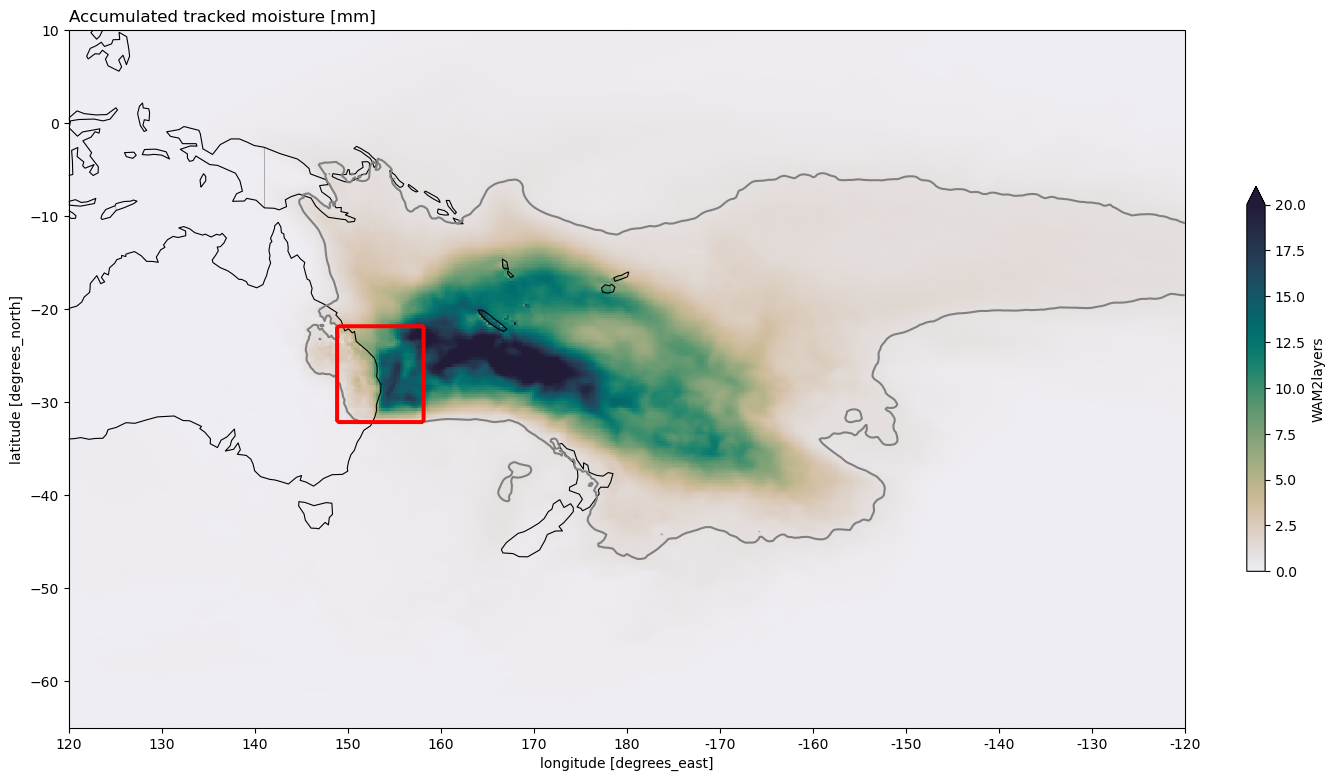

In [17]:
# Make sample figure (in this case of WAM2layers)
prj180 = crs.PlateCarree(central_longitude=180)
prj = crs.PlateCarree()

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection=prj180)
ax.set_xticks(np.arange(0, 361, 10), crs=prj)
ax.set_yticks(np.arange(-90, 91, 10), crs=prj)
lon_formatter = LongitudeFormatter(direction_label=False, degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)

ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

src = merged_aus2[modn[2]]  # WAM2layers for #3
src.plot(
        vmin=0, #Min source in mm
        vmax=20, #Max source in mm
        robust=False,
        cmap=cm.rain, #Colour map from cmocean package
        cbar_kwargs=dict(fraction=0.05, shrink=0.5),
        transform = prj
    )
src.plot.contour(ax=ax, levels=[1], colors=["grey"], transform = prj)
maskr.plot.contour(ax=ax, colors=['red'], transform = prj)
ax.set_title("Accumulated tracked moisture [mm]", loc="left")

ax.set_extent([120, 240, -65, 10], prj)

# plt.savefig("Wam2layers_sources_Australia.png")

## Uncorrected plot of moisture sources

Drawing:  2LDRM
Drawing:  UVigo M1
Drawing:  UVigo M2
Drawing:  UTrack_E1
Drawing:  Lagranto_CHc
Drawing:  HAMSTER E5
Drawing:  FLEXPART-XU
Drawing:  FLEXPART-Watersip E1
Drawing:  FLEXPART-UniVie
Drawing:  BTrIMS
CPU times: user 3min 3s, sys: 4.37 s, total: 3min 7s
Wall time: 3min 1s


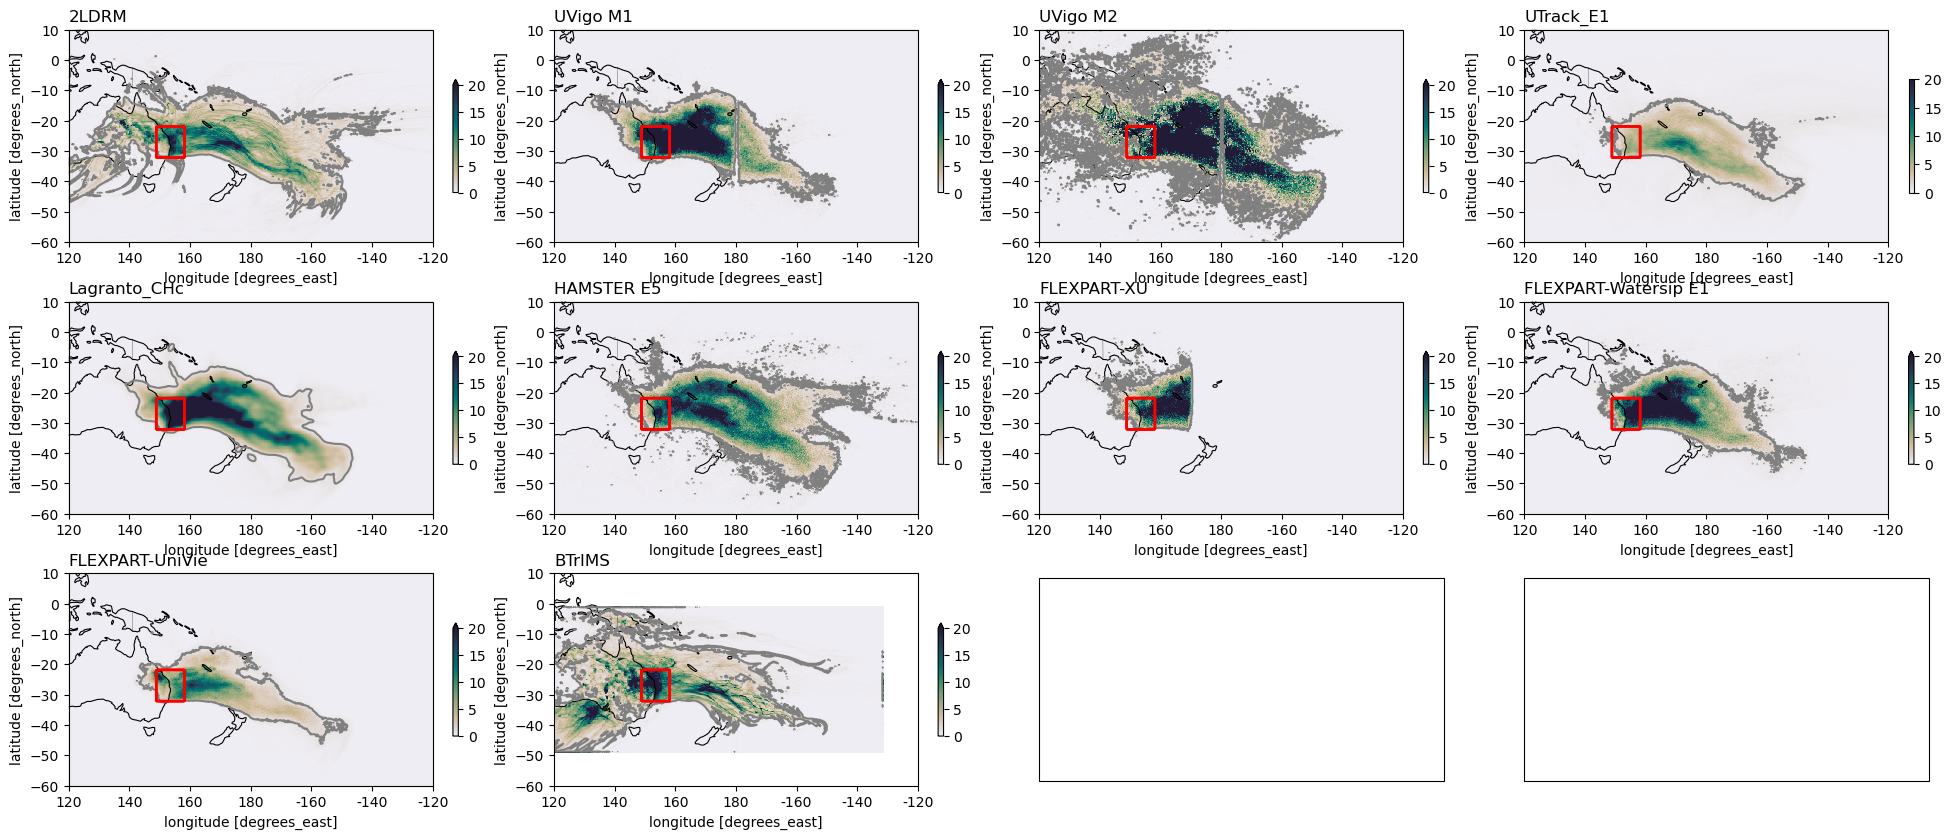

In [27]:
%%time
prj180 = crs.PlateCarree(central_longitude=180)
prj = crs.PlateCarree()

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(24, 10), subplot_kw={'projection': prj180})

for i, ax in enumerate(fig.axes):  
    if i >= len(unique):
        continue
        
    src = merged_aus2[modn[unique[i]]]  # bring the result of the selected model
    ttl = mlabel[unique[i]]             # and the label of the model
    
    ax.set_xticks(np.arange(0, 361, 20), crs=prj)   # Setting xticks (0,360)
    ax.set_yticks(np.arange(-90, 91, 10), crs=prj)  # Setting yticks (-90,90)
    lon_formatter = LongitudeFormatter(direction_label=False, degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
        
    src.plot(ax=ax, cmap=cm.rain, vmin=0, vmax=20,
             cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
             transform = crs.PlateCarree(),)
    src.plot.contour(ax=ax, levels=[1], colors=["grey"], transform = prj)
    maskr.plot.contour(ax=ax, colors=['red'], transform = prj)
    ax.set_title(ttl, loc='left')
    ax.set_extent([120, 240, -60, 10], prj)
    print('Drawing: ', ttl)

fig.savefig("MoistureSources_Australia_reduced.png",dpi=300)